# 1. Reading From Dataset

In [10]:
import numpy as np
import matplotlib.pyplot as plt

NUMBER_OF_PIXELS = 784

To read from the files, we construct a function named `read_from_file` that does nothing but that.We know where to look for each data based on the information given by MNIST

In [11]:
def read_from_file(image_address, label_address):
    images_file = open(image_address, 'rb')
    images_file.seek(4)  # Positions the cursor to the 4th byte.
    number_of_images = int.from_bytes(images_file.read(4), 'big')  # reads 4 bytes in big endian order
    images_file.seek(16)  # Positions the cursor to the 16th byte.
    
    labels_file = open(label_address, 'rb')
    labels_file.seek(8)
    
    result_set = []
    for n in range(number_of_images):
        image = np.zeros((NUMBER_OF_PIXELS, 1))
        for i in range(NUMBER_OF_PIXELS):
            image[i, 0] = int.from_bytes(images_file.read(1), 'big') / 255

        label_value = int.from_bytes(labels_file.read(1), 'big')
        label = np.zeros((10, 1))  # Since we have 10 numbers from 0 to 9
        label[label_value, 0] = 1

        result_set.append((image, label))
    
    return result_set

then we call that function to create our train & test set

In [13]:
train_set = read_from_file("train-images.idx3-ubyte", "train-labels.idx1-ubyte")
test_set = read_from_file("t10k-images.idx3-ubyte", "t10k-labels.idx1-ubyte")

At the end of this section, we plot an image just to make sure we've done this part rightly.

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.]])

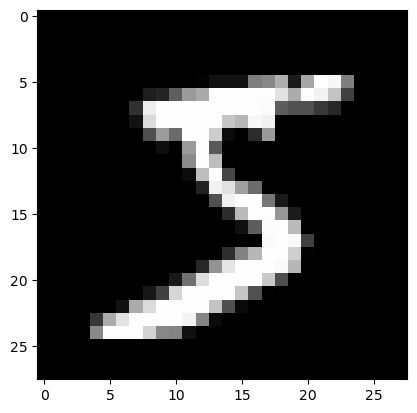

In [14]:
plt.imshow(train_set[0][0].reshape(28, -1), 'gray')
train_set[0][1]

# 2. Feedforward
As we all know, in order to calculate output in a neural network based on inputs, we must apply the following formula on each layer:  
$$a^{(L+1)} = \sigma(W^{(L+1)}× a^{(L)} + b^{(L+1)})$$

Therefore in implementation, for weights between layers, we assign a k×n matrix. Assume "k" is the number of neurons on the next layer, and "n" is the number of neurons on the current layer. As a result, the weights of a single neuron on the next layer are shown in each row of our matrix W.

In [15]:
# Allocate W matrix and vector b for each layer.

# Initialize W from standard normal distribution
W1 = np.random.normal(size=(16, NUMBER_OF_PIXELS))
W2 = np.random.normal(size=(16, 16))
W3 = np.random.normal(size=(10, 16))

# Initialize b = 0, for each layer.
b1 = np.zeros((16, 1))
b2 = np.zeros((16, 1))
b3 = np.zeros((10, 1))

In [16]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

At this step of this project, after initializing W matrices and bias vectors, we separate the first 100 images of our train dataset and calculate the output of that based on the given formula.

In the end, we report the accuracy, which is the number of true estimations divided by the number of images (which is 100 in our scenario). Regarding that the learning process has not proceeded, we expect to have an accuracy of around 10%.

In [17]:
number_of_correct_estimations = 0
total_numbers = 100

for train_data in train_set[:total_numbers]:
    a0 = train_data[0]
    a1 = sigmoid(W1 @ a0 + b1)
    a2 = sigmoid(W2 @ a1 + b2)
    a3 = sigmoid(W3 @ a2 + b3)
    
    predicted_number = np.where(a3 == np.amax(a3))
    real_number = np.where(train_data[1] == np.amax(train_data[1]))
    
    if predicted_number == real_number:
        number_of_correct_estimations += 1

print(f"Accuracy: {number_of_correct_estimations / total_numbers}")

Accuracy: 0.13


# 3. Vectorization

We have implemented the last section (Feedforward) in a vectorized way. Now we're attempting to do the same thing with backpropagation.
___

In vectorized notiation, we have:
$$Cost =(\overrightarrow{a}^{(3)} - \overrightarrow{y})^{T}(\overrightarrow{a}^{(3)} - \overrightarrow{y})$$
The activation vector at the last layer is equal to:
$$\overrightarrow{a}^{(3)} = \sigma(\overrightarrow{z}^{(3)})$$
And $\overrightarrow{z}^{(3)}$ is equal to:
$$\overrightarrow{z}^{(3)} = W^{(3)}\overrightarrow{a}^{(2)} + \overrightarrow{b}^{(2)}$$
### The last layer
##### Weight
$$\displaystyle \frac{\partial Cost}{\partial W^{(3)}} = 2(\overrightarrow{a}^{(3)} - \overrightarrow{y})\overrightarrow{a}^{(3)}(1 - \overrightarrow{a}^{(3)}) \bullet \overrightarrow{a}^{(2)}$$
##### Bias
$$\displaystyle \frac{\partial Cost}{\partial \overrightarrow{b}^{(3)}} = 2 (\overrightarrow{a}^{(3)} - \overrightarrow{y}) \overrightarrow{a}^{(3)}(1 - \overrightarrow{a}^{(3)})$$
##### Activation
$$\displaystyle \frac{\partial Cost}{\partial \overrightarrow{a}^{(2)}} = {W_{3}^{T}} (2(\overrightarrow{a}^{(3)} - \overrightarrow{y}) \overrightarrow{a}^{(3)}(1 - \overrightarrow{a}^{(3)})) $$

### 3rd Layer
##### Weight
$$\displaystyle \frac{\partial Cost}{\partial W^{(2)}} = \displaystyle \frac{\partial Cost}{\partial \overrightarrow{a}^{(2)}}\overrightarrow{a}^{(2)}(1 - \overrightarrow{a}^{(2)}) \bullet \overrightarrow{a}^{(1)}$$
##### Bias
$$\displaystyle \frac{\partial Cost}{\partial \overrightarrow{b}^{(2)}} = (\displaystyle \frac{\partial Cost}{\partial \overrightarrow{a}^{(2)}})\overrightarrow{a}^{(2)}(1 - \overrightarrow{a}^{(2)})$$
##### Activation 
$$\displaystyle \frac{\partial Cost}{\partial \overrightarrow{a}^{(1)}} = {W_{2}^{T}} (\displaystyle \frac{\partial Cost}{\partial \overrightarrow{a}^{(2)}}) \overrightarrow{a}^{(2)}(1 - \overrightarrow{a}^{(2)})) $$

### 2nd
##### Weight
$$\displaystyle \frac{\partial Cost}{\partial W^{(1)}} = \displaystyle \frac{\partial Cost}{\partial \overrightarrow{a}^{(1)}}\overrightarrow{a}^{(1)}(1 - \overrightarrow{a}^{(1)}) \bullet \overrightarrow{a}^{(0)}$$
##### Bias
$$\displaystyle \frac{\partial Cost}{\partial \overrightarrow{b}^{(1)}} = (\displaystyle \frac{\partial Cost}{\partial \overrightarrow{a}^{(1)}})\overrightarrow{a}^{(1)}(1 - \overrightarrow{a}^{(1)})$$

In [20]:
# Hyperparameters
batch_size = 10
learning_rate = 1
number_of_epochs = 20

In [21]:
%%time
# Allocate W matrix and vector b for each layer.

# Initialize W with random normal distribution for each layer. 
W1 = np.random.normal(size=(16, NUMBER_OF_PIXELS))
W2 = np.random.normal(size=(16, 16))
W3 = np.random.normal(size=(10, 16))

# Initialize b = 0, for each layer.
b1 = np.zeros((16, 1))
b2 = np.zeros((16, 1))
b3 = np.zeros((10, 1))

total_costs = []
batches = [train_set[x:x+batch_size] for x in range(0, 100, batch_size)]
for epoch in range(number_of_epochs):
    for batch in batches:
        # allocate grad_W matrix for each layer
        grad_W1 = np.zeros((16, NUMBER_OF_PIXELS))
        grad_W2 = np.zeros((16, 16))
        grad_W3 = np.zeros((10, 16))
        # allocate grad_b for each layer
        grad_b1 = np.zeros((16, 1))
        grad_b2 = np.zeros((16, 1))
        grad_b3 = np.zeros((10, 1))
        
        for image, label in batch:
            # compute the output (image is equal to a0)
            a1 = sigmoid(W1 @ image + b1)
            a2 = sigmoid(W2 @ a1 + b2)
            a3 = sigmoid(W3 @ a2 + b3)
            
            # ---- Last layer
            # weight
            grad_W3 += (2 * (a3 - label) * a3 * (1 - a3)) @ np.transpose(a2)
            
            # bias
            grad_b3 += 2 * (a3 - label) * a3 * (1 - a3)
            
            # ---- 3rd layer
            # activation
            delta_3 = np.zeros((16, 1))
            delta_3 += np.transpose(W3) @ (2 *(a3 - label) * (a3 * (1 - a3)))
            
            # weight
            grad_W2 += (a2 * (1 - a2) * delta_3) @ np.transpose(a1)
            
            # bias
            grad_b2 += delta_3 * a2 * (1 - a2)
                    
            # ---- 2nd layer
            # activation
            delta_2 = np.zeros((16, 1))
            delta_2 += np.transpose(W2) @ delta_3 * a2 * (1 - a2)
            
            # weight
            grad_W1 += (delta_2 * a1 * (1 - a1)) @ np.transpose(image)
                    
            # bias
            grad_b1 += delta_2 * a1 * (1 - a1)
        
        W3 = W3 - (learning_rate * (grad_W3 / batch_size))
        W2 = W2 - (learning_rate * (grad_W2 / batch_size))
        W1 = W1 - (learning_rate * (grad_W1 / batch_size))
        
        b3 = b3 - (learning_rate * (grad_b3 / batch_size))
        b2 = b2 - (learning_rate * (grad_b2 / batch_size))
        b1 = b1 - (learning_rate * (grad_b1 / batch_size))
    
    # calculate cost average per epoch
    cost = 0
    for train_data in train_set[:100]:
        a0 = train_data[0]
        a1 = sigmoid(W1 @ a0 + b1)
        a2 = sigmoid(W2 @ a1 + b2)
        a3 = sigmoid(W3 @ a2 + b3)

        for j in range(10):
            cost += np.power((a3[j, 0] - train_data[1][j,  0]), 2)
            
    cost /= 100
    total_costs.append(cost)    

CPU times: total: 281 ms
Wall time: 292 ms


Accuracy: 0.64


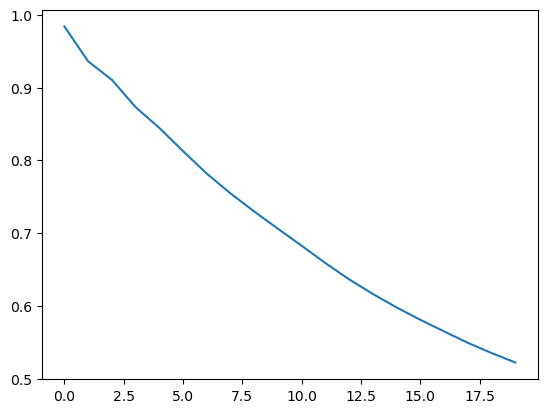

In [22]:
epoch_size = [x for x in range(number_of_epochs)]
plt.plot(epoch_size, total_costs)
number_of_correct_estimations = 0
for train_data in train_set[:100]:
    a0 = train_data[0]
    a1 = sigmoid(W1 @ a0 + b1)
    a2 = sigmoid(W2 @ a1 + b2)
    a3 = sigmoid(W3 @ a2 + b3)
    
    predicted_number = np.where(a3 == np.amax(a3))
    real_number = np.where(train_data[1] == np.amax(train_data[1]))
    
    if predicted_number == real_number:
        number_of_correct_estimations += 1
        
print(f"Accuracy: {number_of_correct_estimations / 100}")

# 4. Testing the model
We use all of our data (60k images) to learn our model now that we've optimized our implementation. Finally, we measure the model's accuracy using test results.

In [23]:
batch_size = 50
learning_rate = 1
number_of_epochs = 5

In [24]:
%%time
total_costs = []
# Initialize W with random normal distribution for each layer.
W1 = np.random.normal(size=(16, NUMBER_OF_PIXELS))
W2 = np.random.normal(size=(16, 16))
W3 = np.random.normal(size=(10, 16))

# Initialize b = 0, for each layer.
b1 = np.zeros((16, 1))
b2 = np.zeros((16, 1))
b3 = np.zeros((10, 1))

for epoch in range(number_of_epochs):
    np.random.shuffle(train_set)
    batches = [train_set[x:x+batch_size] for x in range(0, len(train_set), batch_size)]
    for batch in batches:
        # allocate grad_W matrix for each layer
        grad_W1 = np.zeros((16, NUMBER_OF_PIXELS))
        grad_W2 = np.zeros((16, 16))
        grad_W3 = np.zeros((10, 16))
        # allocate grad_b for each layer
        grad_b1 = np.zeros((16, 1))
        grad_b2 = np.zeros((16, 1))
        grad_b3 = np.zeros((10, 1))
        
        for image, label in batch:
            # compute the output (image is equal to a0)
            a1 = sigmoid(W1 @ image + b1)
            a2 = sigmoid(W2 @ a1 + b2)
            a3 = sigmoid(W3 @ a2 + b3)
            
            # ---- Last layer
            # weight
            grad_W3 += (2 * (a3 - label) * a3 * (1 - a3)) @ np.transpose(a2)
            
            # bias
            grad_b3 += 2 * (a3 - label) * a3 * (1 - a3)
            
            # ---- 3rd layer
            # activation
            delta_3 = np.zeros((16, 1))
            delta_3 += np.transpose(W3) @ (2 *(a3 - label) * (a3 * (1 - a3)))
            
            # weight
            grad_W2 += (a2 * (1 - a2) * delta_3) @ np.transpose(a1)
            
            # bias
            grad_b2 += delta_3 * a2 * (1 - a2)
                    
            # ---- 2nd layer
            # activation
            delta_2 = np.zeros((16, 1))
            delta_2 += np.transpose(W2) @ delta_3 * a2 * (1 - a2)
            
            # weight
            grad_W1 += (delta_2 * a1 * (1 - a1)) @ np.transpose(image)
                    
            # bias
            grad_b1 += delta_2 * a1 * (1 - a1)
        
        W3 = W3 - (learning_rate * (grad_W3 / batch_size))
        W2 = W2 - (learning_rate * (grad_W2 / batch_size))
        W1 = W1 - (learning_rate * (grad_W1 / batch_size))
        
        b3 = b3 - (learning_rate * (grad_b3 / batch_size))
        b2 = b2 - (learning_rate * (grad_b2 / batch_size))
        b1 = b1 - (learning_rate * (grad_b1 / batch_size))
    
    # calculate cost average per epoch
    cost = 0
    for train_data in train_set:
        a0 = train_data[0]
        a1 = sigmoid(W1 @ a0 + b1)
        a2 = sigmoid(W2 @ a1 + b2)
        a3 = sigmoid(W3 @ a2 + b3)

        for j in range(10):
            cost += np.power((a3[j, 0] - train_data[1][j,  0]), 2)
            
    cost /= 100
    total_costs.append(cost)    

CPU times: total: 45.6 s
Wall time: 45.7 s


Accuracy: 89.24


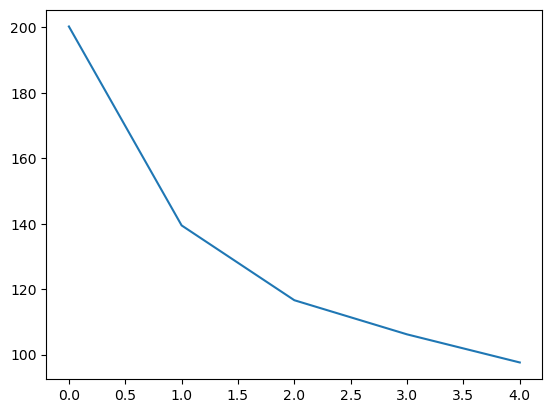

In [25]:
epoch_size = [x for x in range(number_of_epochs)]
plt.plot(epoch_size, total_costs)
number_of_correct_estimations = 0
for test_data in test_set:
    a0 = test_data[0]
    a1 = sigmoid(W1 @ a0 + b1)
    a2 = sigmoid(W2 @ a1 + b2)
    a3 = sigmoid(W3 @ a2 + b3)
    
    predicted_number = np.where(a3 == np.amax(a3))
    real_number = np.where(test_data[1] == np.amax(test_data[1]))
    
    if predicted_number == real_number:
        number_of_correct_estimations += 1
        
print(f"Accuracy: {number_of_correct_estimations / 100}")